In [2]:
import numpy as np 
import random
import matplotlib.pyplot as plt
from numba import jit, float64, int64


In [3]:
#Position0 = np.array([0.0 for x in range(N)])

dt = 0.01 #pimc 温度步长
totalEF=[0,0]
initializer = np.array([1,2,3])

def Kinetic(x,y,z,dt):#计算动能改变量
    return(1/2*((x-y)**2+(y-z)**2)*(1/dt))
#@jit(nopython=True)
def T(x,dt):#计算动能
    y=x-np.roll(x,1)
    return(np.dot(y,y)/2*(1/dt))
@jit(nopython=True)
def Potential(x,dt):#计算势能
    return(np.sum(1/2*x**2)*dt)

_=T(initializer,dt)
_=Potential(initializer,dt)

PIMC
$Z=\int D q(t) exp(-\int_{0}^\beta \frac{1}{2}(\dot{q(t)}^2 + q^2 ) )$


In [4]:
def PIMC(Position,U,N):#随机偏移采样;U:收敛指标；b：温度；N：长度,Ndt=beta
    x = random.randint(0,N-1)#选择粒子
    px = Position[x]
    prex = Position[(x-1)%N]
    nex = Position[(x+1)%N]
    move = np.random.normal(loc=0.0, scale=dt, size=None)
    DT = -Kinetic(prex,px,nex,dt) + Kinetic(prex,px + move,nex,dt) #改变一个粒子的动能变化
    DV = Potential(px + move,dt) -Potential(px,dt) #改变一个粒子的势能变化
    p = DT +DV
    #print(p)
    
    if p <= 0: #δS < 0; 立即接收
        Position[x] += move
        totalEF[0] += 1 #有效操作
        totalEF[1] += 1
        return(Position,U+DT+DV)
    elif np.exp(-p)> random.random(): 
            Position[x] += move
            totalEF[0] += 1
            totalEF[1] += 1
            return(Position,U+DT+DV)
    totalEF[0] += 0
    totalEF[1] += 1
    return(Position,U) #什么也没干
    

现在推导两端固定的粒子链如何更新。
$$\delta T = \frac{1}{2}(\sum(x_i - x_{i+1})^2/dt) $$
$$=1/(2 dt)*(-2 x_0*x_1 + 2 x_1^2 -2x_1x_2+... -2x_{n}x_{n+1} )$$
$$=1/(2 dt)*(-2 x_0x_1-2x_{n+1}x_n + x^T A x) $$
设其为$1/(2 dt)*(-2 x*b + x^T A x)$,其中$b = (x_0,0,0,...,x_{n+1})$
故$$\delta T = 1/(2 dt) ((x-c)^T A (x-c)-c^T A c )$$
其中要求$Ac=b$.容易猜出 $$c=(x_0+\delta,x_0+2\delta,...,x_0+n\delta)$$
其中$\delta = (x_1 -x_0)/(n+1) $.
另一方面，由于A是著名的三对角矩阵：
$$
A = \begin{bmatrix}
2 & -1 & 0 & 0 & 0 \\
-1 & 2 & -1 & 0 & 0 \\
0 & -1 & 2 & -1 & 0 \\
0 & 0 & -1 & 2 & -1 \\
0 & 0 & 0 & -1 & 2
\end{bmatrix}
$$
很容易将其对角化。事实上，其本征值为$$2-2cos(\frac{k\pi}{n+1})$$，本征矢为$$v_{kj}=\sqrt{\frac{2}{n+1}} sin(\frac{kj\pi}{n+1})$$

最终得到
$$\delta T = 1/2 dt \sum(c_k^2 \lambda_k )$$
其中$c_k = x.v_k$,所有模态解耦为Gaussian分布，$\sigma^{-2}= 1/dt *(2-2cos(\frac{k\pi}{n+1}))$
现在用python验证一下：

In [18]:


n = 3
A = np.diag([2]*n) + np.diag([-1]*(n-1), k=1) + np.diag([-1]*(n-1), k=-1)

# 计算本征值和本征向量
eigvals, eigvecs = np.linalg.eigh(A)

print("理论本征值：", [2 - 2*np.cos(k*np.pi/(n+1)) for k in range(1, n+1)])
print("实际计算本征值：", eigvals.round(6))
print("归一化后的本征向量（列）：\n", eigvecs.round(3))
print(np.sqrt(2/(n+1))*np.array([np.sin(k*np.pi/(n+1)) for k in range(1,n+1)]))

理论本征值： [0.5857864376269049, 1.9999999999999998, 3.414213562373095]
实际计算本征值： [0.585786 2.       3.414214]
归一化后的本征向量（列）：
 [[-0.5   -0.707  0.5  ]
 [-0.707  0.    -0.707]
 [-0.5    0.707  0.5  ]]
[0.5        0.70710678 0.5       ]


In [7]:

@jit(nopython=True)
def vk(k, n):
    """Calculate eigenvector"""
    return np.sqrt(2/(n+1)) * np.sin(k * np.pi * np.arange(1, n+1) / (n+1))

@jit(nopython=True)
def lambdak(k, n):
    """Calculate eigenvalue"""
    return 2 - 2 * np.cos(k * np.pi / (n+1))

@jit(nopython=True)
def random_fix(n, x0, xn, dt):
    """Generate random path with fixed endpoints"""
    delta = (xn - x0) / (n + 1)
    x = np.arange(1, n+1) * delta   # Linear interpolation
    x += np.ones_like(x) * x0
    for k in range(1, n+1):
        lamb = lambdak(k, n)
        c_k = np.random.normal(0, np.sqrt(dt/lamb))
        x += c_k * vk(k, n)
    
    return x


In [8]:
# 参数设置
n, x0, xn, dt = 100, 0.0, 0.0, 0.01
num_trials = 1000

# 预热JIT编译
_ = random_fix(n, x0, xn, dt)

In [9]:
def calculate_kinetic(path, dt):
    """Calculate kinetic energy of a path
    
    Args:
        path (np.ndarray): Path coordinates
        dt (float): Time step
    
    Returns:
        float: Kinetic energy
    """
    differences = np.diff(path)  # x_{i+1} - x_i
    T1 = np.sum(differences**2) / (2*dt)
    return T1

# Test parameters
N = 100
dt = 0.01
num_samples = 1000

# Generate many paths and calculate average kinetic energy
kinetic_energies = []
for _ in range(num_samples):
    path = random_fix(N-2, 0.0, 0.0, dt)  # N-2 interior points
    full_path = np.concatenate([[0.0], path, [0.0]])  # Add fixed endpoints
    T0 = calculate_kinetic(full_path, dt)
    kinetic_energies.append(T0)

mean_T0 = np.mean(kinetic_energies)
std_T0 = np.std(kinetic_energies)
print(f"Average kinetic energy: {mean_T0:.2f} ± {std_T0:.2f}")
print(f"Theoretical expectation: 49.5")

Average kinetic energy: 48.86 ± 6.91
Theoretical expectation: 49.5


In [10]:
def init(beta):
    N=int(beta//dt)
    position0 = np.array(random_fix(N,0,0,dt))
    #position0 += np.array([-5 for  x in range(N)])
    return(position0)

In [11]:
accpted = False

In [12]:
def pimc_shift(Position,U,r,N,mean_x2):#multi-particle move, r为移动粒子的比例
    #Q2 = Q #方差
    num_move = int(r*N)+1#;print(num_move) #长度.不要取r = 1.
    num_0 = int(np.random.random()*N)#;print(num_0)#起始点
    x0 = Position[(num_0-1)]#;print(x0)
    x1 = Position[(num_0 +num_move+1)%N]#;print(x1)
    new =  random_fix(num_move,x0,x1,dt)#;print('NEW',new[0],new[-1])
    indices = np.arange(num_0, num_0 +num_move)%N #;print(indices) #移动的粒子
    old = Position[indices] #;print('OLD',old[0],old[-1])
    p1 = Potential(new,dt) - Potential(old,dt) #势能变化
    global accpted
    accpted = True
    if p1<=0:
        Position[indices] = new
        mean_x2 += np.dot(new,new) - np.dot(old,old)
        return(Position,U+p1,mean_x2)
    else:
        if np.exp(-p1)>= np.random.random():
            mean_x2 += np.sum(new**2) - np.sum(old**2)
            Position[indices] = new
            #print(p1,new)
            return(Position,U+p1,mean_x2)
        else:
            accpted = False#;print('denied')
            return(Position,U,mean_x2) #构型，收敛指标，方差

In [13]:
def autorun(n,r,position0):#步数, num_move，初始位置 
    N = len(position0) #规定长度=温度/dt
    position = position0 
    U = Potential(position,dt); M_x2 = np.dot(position,position)
    action = []
    mean_dev = []
    acc = 0
    apt = 0
    for i in range(n):
        action.append(U); mean_dev.append(M_x2)
        apt += 1
        if acc/apt < 0.3 or r > 0.9:
            r = r*0.95
        elif acc/apt > 0.8:
            r = r*1.05
        position,U,M_x2 = pimc_shift(position,U,r,N,M_x2)
        if accpted:
            acc += 1
    print( 'current accpted rate:',acc/apt)
    return(position,action,mean_dev)


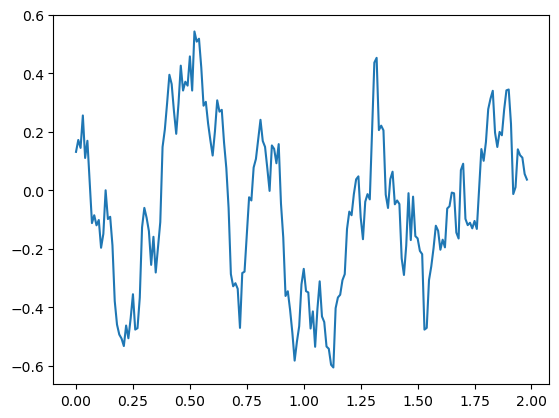

current accpted rate: 0.7896296296296297


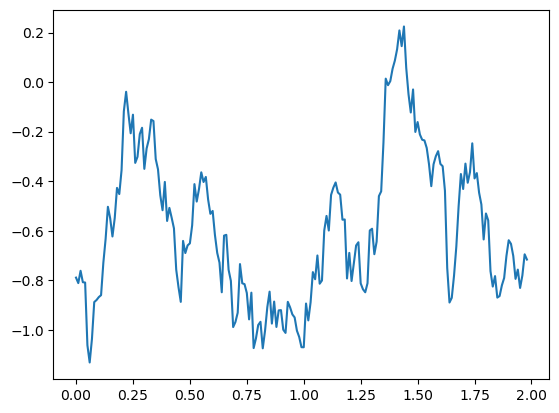

Mean x^2 0.6223507275147816


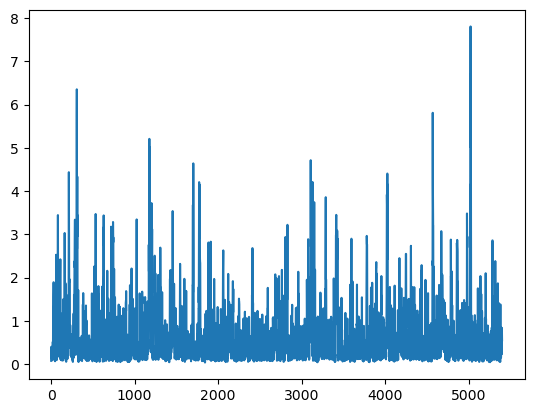

In [14]:


beta = 2
dt = 0.01
p = init(beta)
iter = int(5500*2/(beta+0.5)+1000)
plt.plot([x*dt for x in range(len(p))],p)
plt.show()
p2,u2,x2 = autorun(iter,0.5,p)
plt.plot([x*dt for x in range(len(p2))],p2)
plt.show()
plt.plot([x  for x in range(len(x2))],np.array(x2)/(len(p2)))
print('Mean x^2',np.mean(x2[iter//3:])/(len(p2)))

In [15]:
print(Potential(p2,dt),T(p2,dt))

0.4382229246509395 98.55729958083185


In [19]:
xx = []; log = []
for i in range(10):
    beta = 0.5 + 0.2 *i
    dt = 0.02/beta
    p = init(beta)
    iter = int(9000*2/(beta+1)+1000)
    p2,u2,x2 = autorun(iter,0.5,p)
    mean_q2 = np.mean(x2[iter//4:])/(len(p2))
    xx.append(mean_q2);log.append(x2)
    print('Mean x^2',mean_q2)

current accpted rate: 0.9434615384615385
Mean x^2 2.2065179412933804
current accpted rate: 0.915688643424232
Mean x^2 1.5350027928436114
current accpted rate: 0.897928005347083
Mean x^2 1.1717977778299837
current accpted rate: 0.8643819872531606
Mean x^2 1.0768546779472463
current accpted rate: 0.851234987536823
Mean x^2 0.9040893059288728
current accpted rate: 0.8304878048780487
Mean x^2 0.814695226974203
current accpted rate: 0.8163318549439081
Mean x^2 0.7335893891102343
current accpted rate: 0.7905911740216486
Mean x^2 0.6712545582203042
current accpted rate: 0.7594769321187188
Mean x^2 0.6401835028905883
current accpted rate: 0.755810350170437
Mean x^2 0.6323105210827703


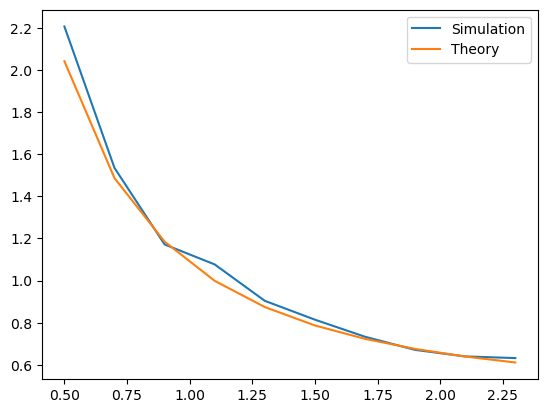

In [20]:
def coth(x):
    return np.cosh(x) / np.sinh(x)

Temp = np.array([0.5 + 0.2 *i for i in range(10)])
plt.plot(Temp,xx,label='Simulation')
plt.plot(Temp,1/2*coth(1/2*Temp),label='Theory')
plt.legend()
plt.show()